在MNIST数据集上训练VAE，并生成新的图片。

In [1]:
from datasets import load_dataset
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
dataset = load_dataset("ylecun/mnist", split="train")
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [3]:
images = dataset["image"]

# 将图片转成一维向量，并归一化到[0, 1]
images = torch.stack([torch.tensor(np.array(img)) for img in images])  # Shape: [60000, 28, 28]
images = images.float() / 255.0
images = images.reshape(-1, 28*28)  # Flatten to [60000, 784]
images

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

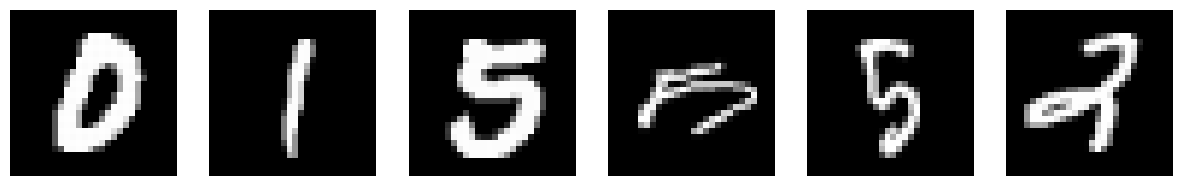

In [4]:
# 先输出看一下原始图像
sampled_indices = random.sample(range(len(images)), 6)
sampled_images = images[sampled_indices]
sampled_images = sampled_images.reshape(-1, 28, 28)

plt.figure(figsize=(15, 3))
for i in range(len(sampled_images)):
    plt.subplot(1, len(sampled_images), i+1)
    plt.imshow(sampled_images[i], cmap='gray')
    plt.axis('off')
plt.show()


In [5]:
class VAE_Encoder(nn.Module):
    """
    VAE的encoder，将输入的图片映射到隐变量的分布，输出隐变量分布的均值和方差.
    由于方差不能为负，所以这里输出的是log(方差)，而不是方差本身.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

class VAE_Decoder(nn.Module):
    """
    VAE的decoder，将隐变量映射回图片.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.decoder(z)

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=500, latent_dim=5):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.encoder = VAE_Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VAE_Decoder(input_dim, hidden_dim, latent_dim)
    
    def encode(self, x):
        """
        将输入的图片映射到隐变量的分布，输出隐变量分布的均值和log(方差).
        """
        return self.encoder(x)

    def decode(self, z):
        """
        将隐变量映射回图片.
        """
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        """
        重参数化技巧，先从标准正态分布中采样一个epsilon，然后根据隐变量分布的均值和方差，计算出隐变量.
        """
        std = torch.exp(0.5 * logvar) # 计算标准差, std = sqrt(var) = sqrt(exp(logvar)) = exp(logvar/2)
        epsilon = torch.randn_like(std, requires_grad=False) # 从标准正态分布中采样epsilon
        return mu + epsilon * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 初始化模型
model = VAE().to(device)

# 定义损失函数
def loss_function(x, recon_x, mu, logvar):
    # 这里要计算ELBO(也就是论文中的$\mathcal{L}$)，但是由于论文中的目标是最大化ELBO，pytorch中是最小化loss，所以这里实际计算的是-ELBO
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # 计算KL散度
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # 计算重构误差，对应论文中的$-\log p_{\theta}(x|z)$，注意BCE loss本身前面有个负号
    return KLD + BCE

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
data_loader = DataLoader(images, batch_size=16, shuffle=True)
for epoch in range(30):
    total_losses = []
    for batch in data_loader:
        batch = batch.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(batch, recon_batch, mu, logvar)
        loss = loss / len(batch)
        total_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {np.mean(total_losses)}")

Using device: cuda
Epoch 1, Loss: 148.218229490153
Epoch 2, Loss: 133.67955553588868
Epoch 3, Loss: 130.16485331420898
Epoch 4, Loss: 128.34097389933268
Epoch 5, Loss: 127.02298073933919
Epoch 6, Loss: 126.11066663818359
Epoch 7, Loss: 125.45338639119466
Epoch 8, Loss: 124.7991173055013
Epoch 9, Loss: 124.37660923665365
Epoch 10, Loss: 123.91466243896484
Epoch 11, Loss: 123.55566061808268
Epoch 12, Loss: 123.19481541137695
Epoch 13, Loss: 122.90625718180338
Epoch 14, Loss: 122.65049377034505
Epoch 15, Loss: 122.41688023885091
Epoch 16, Loss: 122.21278980916341
Epoch 17, Loss: 121.98443272501628
Epoch 18, Loss: 121.90538377685547
Epoch 19, Loss: 121.65059788004557
Epoch 20, Loss: 121.48958971354166
Epoch 21, Loss: 121.35167852376303
Epoch 22, Loss: 121.23478185221354
Epoch 23, Loss: 121.117753902181
Epoch 24, Loss: 120.95256010742187
Epoch 25, Loss: 120.86798016967774
Epoch 26, Loss: 120.76725737508139
Epoch 27, Loss: 120.66725927937826
Epoch 28, Loss: 120.54188850708007
Epoch 29, Loss:

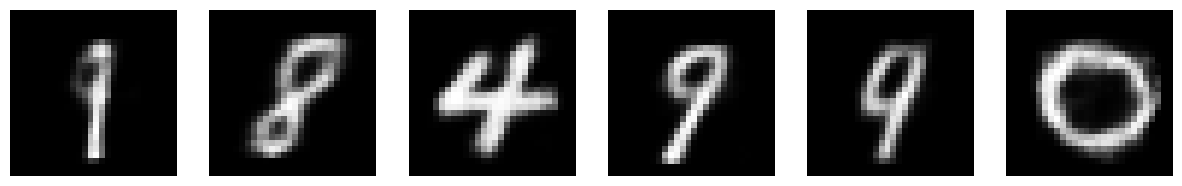

In [6]:
# 生成新的图片
with torch.no_grad():
    z = torch.randn(6, model.latent_dim).to(device)
    recon_batch = model.decode(z)
    recon_batch = recon_batch.view(-1, 28, 28).cpu().numpy()

plt.figure(figsize=(15, 3))
for i in range(len(recon_batch)):
    plt.subplot(1, len(recon_batch), i+1)
    plt.imshow(recon_batch[i], cmap='gray')
    plt.axis('off')
plt.show()
